In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

# GET THE DATA

In [2]:

#file_path= '/priv/debass/DES/SIMS/sims/SNe/for_BBC/hostmpi_W21_bestfit_nostep_mod_z**1.4**testmass/FITOPT000.FITRES'
file_path= '/priv/debass/DES/SIMS/sims/SNe/for_BBC/final_model_v1/fixed_with_neb/null_av0-1/FITOPT010.FITRES'
#file_path= '/priv/debass/DES/SIMS/sims/SNe/for_BBC/final_model_v1/fixed_with_neb/av0-1/FITOPT000.FITRES'
#file_path= '/priv/debass/DES/SIMS/sims/SNe/for_BBC/modified/hostmpi_W21_bestfit_nostep_mod_z**1.5**Av1.0_SDSS/FITOPT000.FITRES'

# Step 1: Find the VARNAMES line
with open(file_path, 'r') as f:
    lines = f.readlines()

column_names = None
for line in lines:
    if line.startswith('VARNAMES:'):
        column_names = line.replace('VARNAMES:', '').strip().split()
        break

if column_names is None:
    raise ValueError("VARNAMES line not found in FITRES file")

# Step 2: Make column names unique
from collections import Counter

counts = Counter()
unique_column_names = []
for name in column_names:
    if counts[name]:
        unique_column_names.append(f"{name}_{counts[name]}")
    else:
        unique_column_names.append(name)
    counts[name] += 1

# Step 3: Find the line number where the SN data starts
data_start_index = None
for i, line in enumerate(lines):
    if line.startswith('SN:'):
        data_start_index = i
        break

if data_start_index is None:
    raise ValueError("Data (SN:) section not found in FITRES file")

# Step 4: Read the data
df = pd.read_csv(
    file_path,
    delim_whitespace=True,
    skiprows=data_start_index,
    names=unique_column_names,
    comment='#'
)

# Preview
print("Columns:", df.columns.tolist())
#print(df)


/tmp/ipykernel_1343928/801181136.py:42: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


Columns: ['CID', 'IDSURVEY', 'TYPE', 'mB', 'mBERR', 'cERR', 'x1ERR', 'zHD', 'TYPE_1', 'zHDERR', 'zCMB', 'zCMBERR', 'zHEL', 'zHELERR', 'x0', 'x0ERR', 'COV_x1_x0', 'COV_c_x0', 'COV_x1_c', 'VPEC', 'VPECERR', 'PKMJD', 'PKMJDERR', 'FITPROB', 'PROB_SNNTRAINV19_z_TRAINDES_V19', 'HOST_LOGMASS', 'HOST_LOG_SFR', 'HOST_LOG_sSFR', 'distmod', 'mass', 'EW_OII', 'ssfr', 'sfr', 'mean_ages', 'SN_age', 'rv', 'E', 'host_Av', 'U-R', 'c', 'c_noise', 'c_int', 'x1', 'x1_int', 'x1_noise']


## PLOT THE DISTRIBUTION OF THE DATA

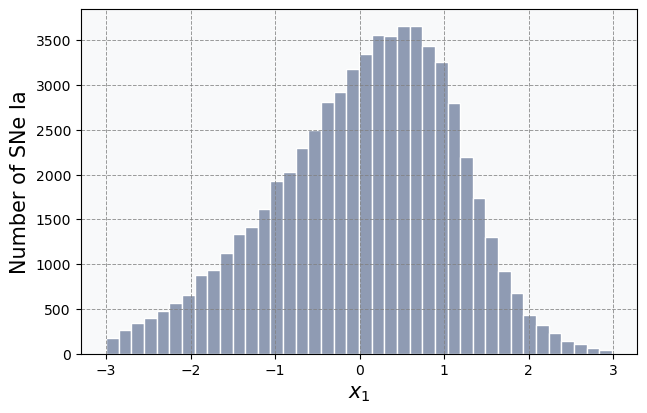

63280
0


In [3]:

columns_to_plot = ['x1']

plt.figure(figsize=(18, 16))
cividis_color = "#8f9bb3"  # A brighter cividis-inspired color


for i, col in enumerate(columns_to_plot, 1):
    if col in df.columns:
        plt.subplot(4, 3, i)
        df[col].dropna().hist(
            bins=40,
            color=cividis_color,
            edgecolor='white'
        )
        if col == 'x1':
            plt.xlabel('$x_1$', fontsize=15)
        elif col == 'c':
            plt.xlabel('$c$', fontsize=15)
        elif col == 'E':
            plt.xlabel('$E$', fontsize=15)
        elif col == 'c_int':
            plt.xlabel('$c_{int}$', fontsize=15)
        else:
            plt.xlabel(col, fontsize=10)
            plt.title(col, fontsize=11)
        plt.ylabel('Number of SNe Ia', fontsize=15)
        plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.8, color="#818181")
        plt.gca().set_facecolor('#f8f9fa')  # light background for subplot
    else:
        print(f"Column '{col}' not found.")

plt.tight_layout()
plt.show()
print(len(df['SN_age']))
print((df['EW_OII'] == 0).sum())




## PLOT THE AGE DISTRIBUTION (CONTOUR PLOT)

/tmp/ipykernel_2107401/3273953929.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fitres_file, delim_whitespace=True, comment='#')  # FITRES is space-delimited


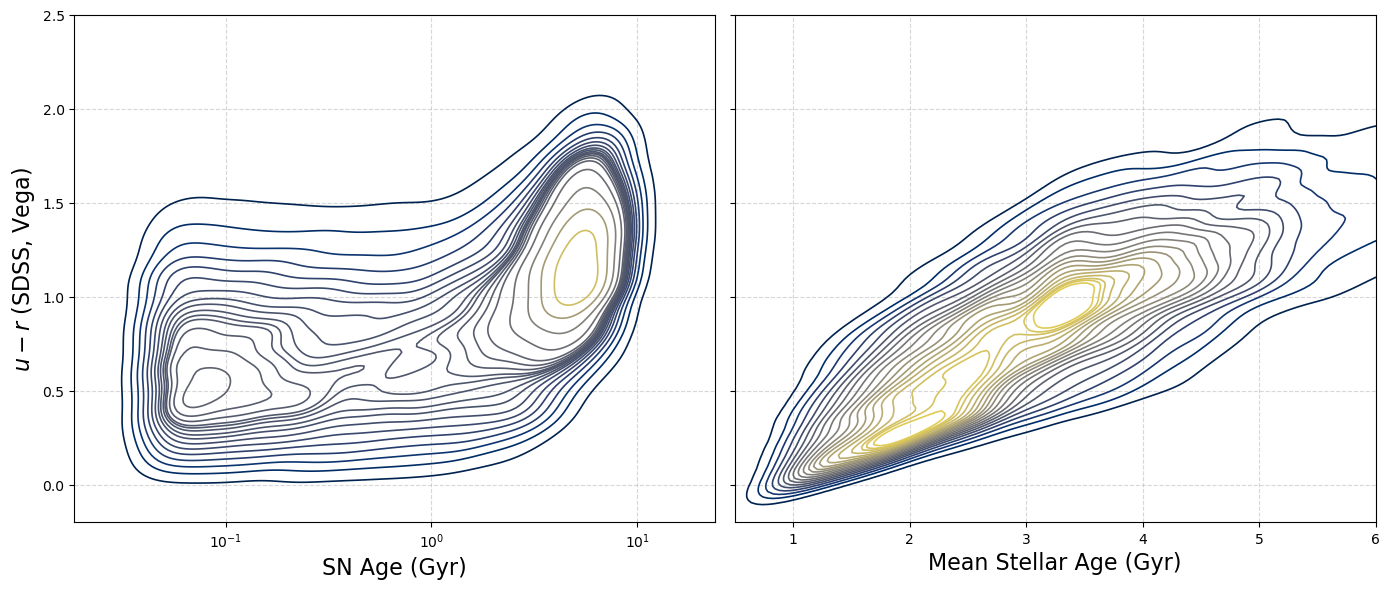

In [4]:

import seaborn as sns
import glob
import os


# --- Initialize Lists ---
z_list, mass_list, u_list, n_list, c_list = [], [], [], [], []
mr_list, x1_list, mean_age_list, sn_age_list = [], [], [], []

# --- Read FITRES Files ---
fitres_file = file_path

try:
    df = pd.read_csv(fitres_file, delim_whitespace=True, comment='#')  # FITRES is space-delimited

    z_list = df["zHD"].values
    mass_list = 10 ** df["HOST_LOGMASS"].values  # Convert log mass to linear
    u_list = df["U-R"].values
    n_list = np.ones(len(df))  # Use 1 as weight
    c_list = df["c"].values
    x1_list = df["x1"].values
    mean_age_list = df["mean_ages"].values
    sn_age_list = df["SN_age"].values

except Exception as e:
    print(f"Error reading {fitres_file}: {e}")


# --- Convert to Arrays ---
sn_age_array = np.array(sn_age_list)
z_array = np.array(z_list)
mass_array = np.array(mass_list)
ur_array = np.array(u_list)
n_array_raw = np.array(n_list)
c_array = np.array(c_list)
x1_array = np.array(x1_list)
mean_age_array = np.array(mean_age_list)
logmass_array = np.log10(mass_array)

# --- Scale weights ---
scaling_factor = 1600 / np.sum(n_array_raw)
n_array = n_array_raw * scaling_factor

# --- Plotting ---
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# 1. U-R vs log(SN Age)
mask_log = sn_age_array > 0
log_sn_age = np.log10(sn_age_array[mask_log])

sns.kdeplot(
    x=log_sn_age,
    y=ur_array[mask_log],
    weights=n_array[mask_log],
    fill=False,
    cmap="cividis",
    ax=axs[0],
    levels=20,
    linewidths=1.2
)

axs[0].set_xticks([-1, 0, 1])
axs[0].set_xticklabels([r'$10^{-1}$', r'$10^{0}$', r'$10^{1}$'])
axs[0].set_xlabel("SN Age (Gyr)", size=16)
axs[0].set_ylabel("$u - r$ (SDSS, Vega)", size=16)
axs[0].set_ylim(0, 2.5)
axs[0].grid(True, linestyle='--', alpha=0.5)

# 2. U-R vs Mean Stellar Age
sns.kdeplot(
    x=mean_age_array / 1000,  # Convert Myr to Gyr
    y=ur_array,
    weights=n_array,
    fill=False,
    cmap="cividis",
    ax=axs[1],
    levels=20,
    linewidths=1.2
)

axs[1].set_xlabel("Mean Stellar Age (Gyr)", size=16)
axs[1].set_ylabel("$u - r$ (SDSS, Vega)", size=16)
axs[1].set_xlim(0.5, 6)
axs[1].set_ylim(-0.2, 2.5)
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()




# OBSERVATIONAL VS SIMULATION

In [5]:
#observational data, merged
input_csv = "df_merged_new.csv"
obs_data= pd.read_csv(input_csv)
obs_color= obs_data["HOST_COLOR"]
obs_mass= obs_data["HOST_LOGMASS"]


In [6]:
# Prepare data
x_mass = np.log10(df["mass"])
y_color = df["U-R"]
x_age = df["mean_ages"] / 1000  # Convert to Gyr

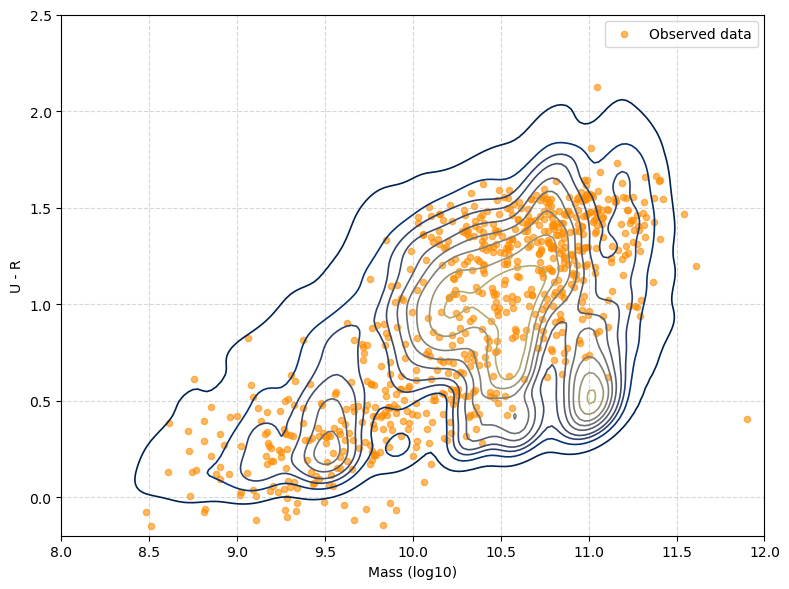

In [7]:

# KDE + scatter overlay
fig, ax = plt.subplots(figsize=(8, 6))

# KDE plot
sns.kdeplot(
    x=x_mass,
    y=y_color,
    ax=ax,
    cmap="cividis",
    fill=False,
    levels=10,
    linewidths=1.2,
    label= "Sim"
)

# Scatter plot overlay
ax.scatter(
    obs_mass,
    obs_color,
    color="darkorange",
    alpha=0.6,
    s=20,
    label="Observed data"
)

# Labels and formatting
ax.set_xlabel("Mass (log10)")
ax.set_ylabel("U - R")
ax.set_xlim(8, 12)
ax.set_ylim(-0.2, 2.5)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()

# Save + show
plt.tight_layout()
plt.show()


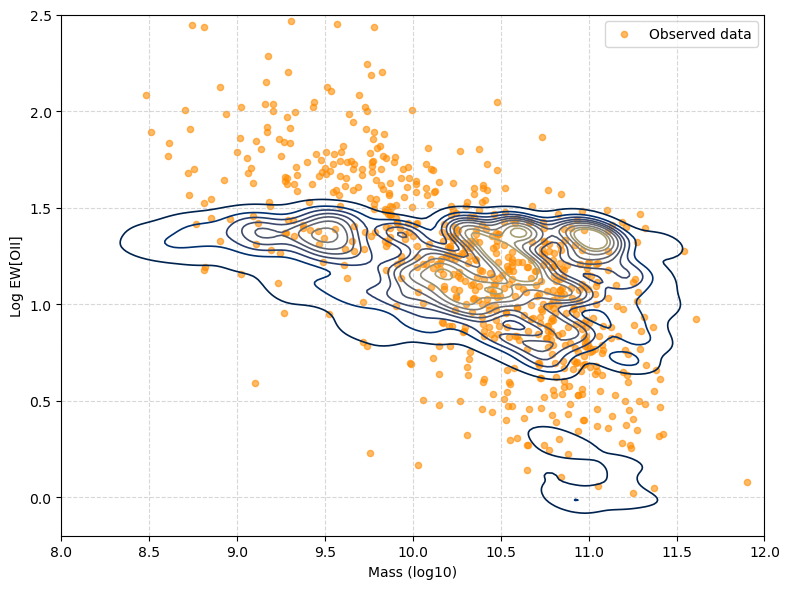

In [9]:

sim_oii= np.log10(df["EW_OII"])  # Assuming EW_OII is in the DataFrame
sim_mass= np.log10(df["mass"])  # Assuming HOST_LOGMASS is in the DataFrame
obs_oii   = obs_data["LOG_OII"]

# KDE + scatter overlay
fig, ax = plt.subplots(figsize=(8, 6))

# KDE plot
sns.kdeplot(
    x=sim_mass,
    y=sim_oii,
    ax=ax,
    cmap="cividis",
    fill=False,
    levels=10,
    linewidths=1.2,
    label= "Sim"
)

# Scatter plot overlay
ax.scatter(
    obs_mass,
    obs_oii,
    color="darkorange",
    alpha=0.6,
    s=20,
    label="Observed data"
)

# Labels and formatting
ax.set_xlabel("Mass (log10)")
ax.set_ylabel("Log EW[OII]")
ax.set_xlim(8, 12)
ax.set_ylim(-0.2, 2.5)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()

# Save + show
plt.tight_layout()
plt.show()


In [ ]:
# some redefinitions just to make it clearer

mask = df["EW_OII"] > 1.0

# Observed data
obs_color = obs_data["HOST_COLOR"]
obs_mass = obs_data["HOST_LOGMASS"]
obs_oii   = obs_data["LOG_OII"]

# Simulated data (replace df with your simulation DataFrame)
sim_color = df["U-R"]    
sim_color_mask = sim_color[mask]
sim_mass = np.log10(df["mass"]) 
sim_mass_mask = sim_mass[mask]      # for first subplot
sim_oii = df["EW_OII"]              # boolean mask
sim_oii_mask = np.log10(sim_oii[mask])   # apply log only to filtered values


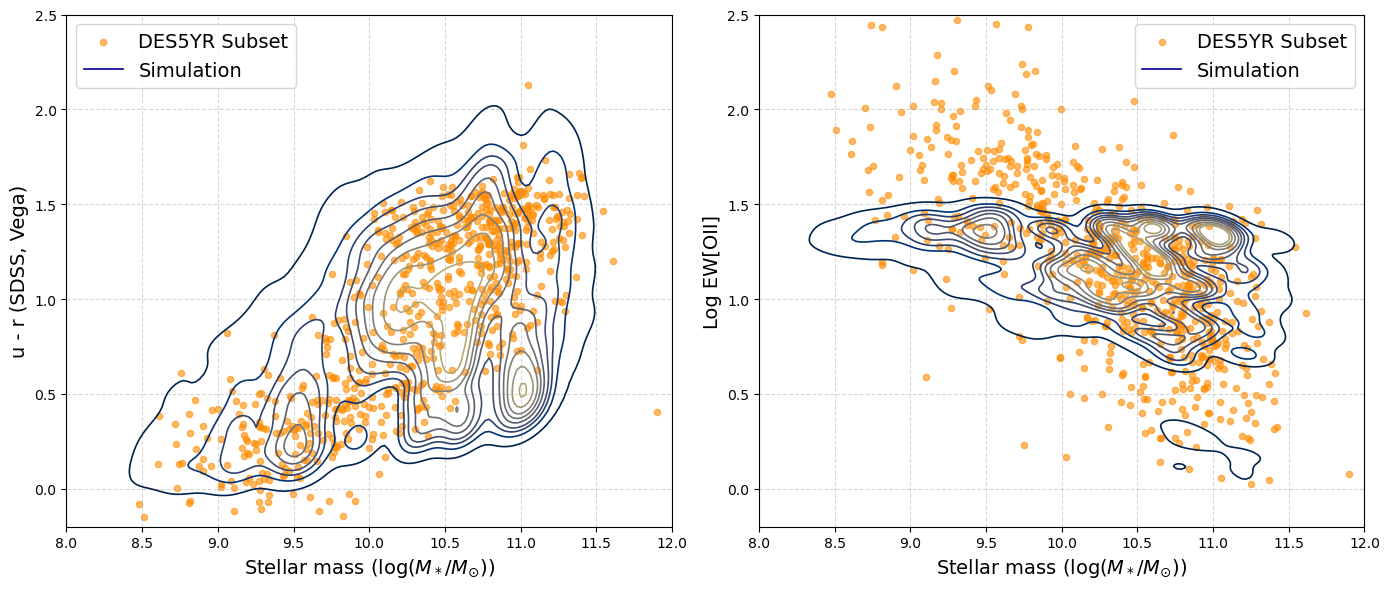

In [11]:

# Create figure with 2 subplots (side by side)
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# --- Subplot 1: Mass vs U-R color ---
sns.kdeplot(
    x=sim_mass_mask,
    y=sim_color_mask,
    ax=axs[0],
    cmap="cividis",
    fill=False,
    levels=10,
    linewidths=1.2
)

axs[0].scatter(
    obs_mass,
    obs_color,
    color="darkorange",
    alpha=0.6,
    s=20,
    label="DES5YR Subset"
)

axs[0].plot([], [], color="darkblue", linewidth=1.2, label="Simulation")
axs[0].set_xlabel("Stellar mass ($\log(M_*/M_{\odot})$)", fontsize=14)
axs[0].set_ylabel("u - r (SDSS, Vega)", fontsize=14)
axs[0].set_xlim(8, 12)
axs[0].set_ylim(-0.2, 2.5)
axs[0].grid(True, linestyle='--', alpha=0.5)
axs[0].legend(fontsize=14)

# --- Subplot 2: Mass vs log EW[OII] ---
sns.kdeplot(
    x=sim_mass_mask,
    y=sim_oii_mask,
    ax=axs[1],
    cmap="cividis",
    fill=False,
    levels=10,
    linewidths=1.2
)

axs[1].scatter(
    obs_mass,
    obs_oii,
    color="darkorange",
    alpha=0.6,
    s=20,
    label="DES5YR Subset"
)
axs[1].plot([], [], color="darkblue", linewidth=1.2, label="Simulation")
axs[1].set_xlabel("Stellar mass ($\log(M_*/M_{\odot})$)", fontsize=14)
axs[1].set_ylabel("Log EW[OII]", fontsize=14)
axs[1].set_xlim(8, 12)
axs[1].set_ylim(-0.2, 2.5)
axs[1].grid(True, linestyle='--', alpha=0.5)
axs[1].legend(fontsize=14)

# Adjust layout and show
plt.tight_layout()
plt.show()


/tmp/ipykernel_2107401/3648974746.py:16: RuntimeWarning: Mean of empty slice
  OII_mean[j-1, i-1] = np.nanmean(obs_oii[mask_bin])


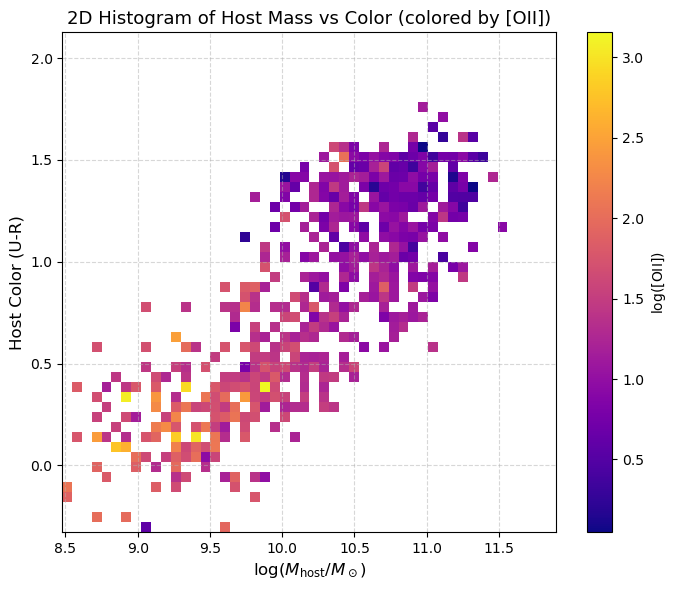

In [12]:
# Create 2D histogram grid (binned mean OII per cell)
nbins = 50
x_edges = np.linspace(obs_mass.min(), obs_mass.max(), nbins)
y_edges = np.linspace(obs_color.min(), obs_color.max(), nbins)

# Digitize into bins
x_idx = np.digitize(obs_mass, x_edges)
y_idx = np.digitize(obs_color, y_edges)

# Create a 2D array of mean OII in each bin
OII_mean = np.full((nbins, nbins), np.nan)
for i in range(1, nbins):
    for j in range(1, nbins):
        mask_bin = (x_idx == i) & (y_idx == j)
        if np.any(mask_bin):
            OII_mean[j-1, i-1] = np.nanmean(obs_oii[mask_bin])

# Plot the 2D histogram (OII color-coded)
plt.figure(figsize=(7,6))
im = plt.imshow(
    OII_mean,
    origin='lower',
    extent=[x_edges.min(), x_edges.max(), y_edges.min(), y_edges.max()],
    aspect='auto',
    cmap='plasma'
)

plt.colorbar(im, label=r'$\log(\mathrm{[OII]})$')
plt.xlabel(r'$\log(M_\mathrm{host}/M_\odot)$', fontsize=12)
plt.ylabel(r'Host Color (U-R)', fontsize=12)
plt.title('2D Histogram of Host Mass vs Color (colored by [OII])', fontsize=13)

plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()


/tmp/ipykernel_2107401/2009390054.py:12: RuntimeWarning: Mean of empty slice
  Z[j-1, i-1] = np.nanmean(z[mask])


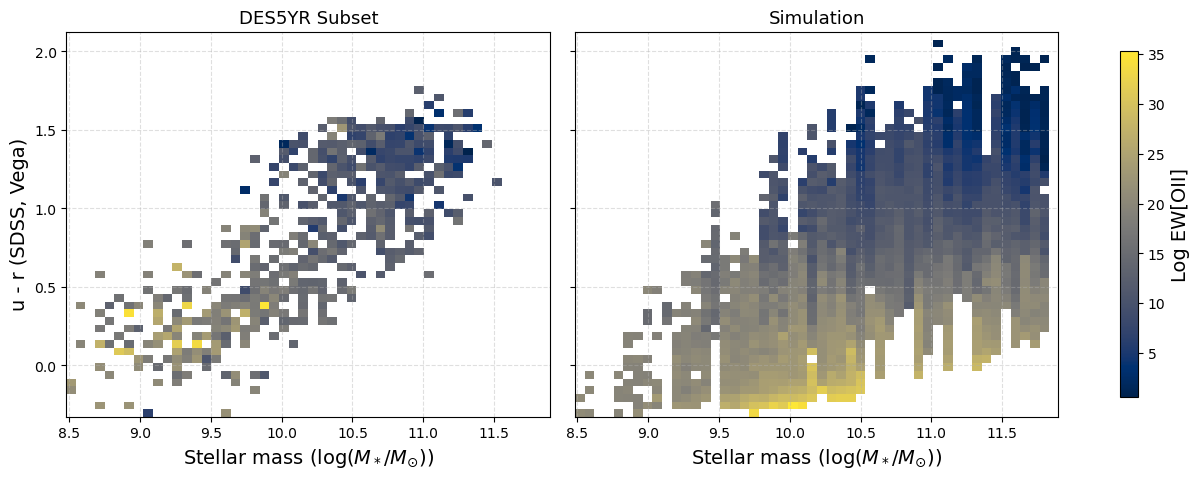

In [13]:
# ==== 2D histogram function ====
def compute_2d_hist(x, y, z, nbins=50):
    x_edges = np.linspace(x.min(), x.max(), nbins)
    y_edges = np.linspace(y.min(), y.max(), nbins)
    x_idx = np.digitize(x, x_edges)
    y_idx = np.digitize(y, y_edges)
    Z = np.full((nbins, nbins), np.nan)
    for i in range(1, nbins):
        for j in range(1, nbins):
            mask = (x_idx == i) & (y_idx == j)
            if np.any(mask):
                Z[j-1, i-1] = np.nanmean(z[mask])
    return Z, x_edges, y_edges

# ==== Compute both ====
obs_Z, x_edges, y_edges = compute_2d_hist(obs_mass, obs_color, obs_oii)
sim_Z, _, _ = compute_2d_hist(sim_mass, sim_color, sim_oii)

# ==== Plot ====
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True, sharey=True,gridspec_kw={'wspace': 0.05})

# Observational data
im1 = axes[0].imshow(
    obs_Z, origin='lower', extent=[x_edges.min(), x_edges.max(), y_edges.min(), y_edges.max()],
    aspect='auto', cmap='cividis'
)
axes[0].set_title("DES5YR Subset", fontsize=13)
axes[0].set_xlabel(r'Stellar mass ($\log(M_*/M_{\odot})$)', fontsize=14)
axes[0].set_ylabel(r'u - r (SDSS, Vega)', fontsize=14)
axes[0].grid(alpha=0.4, linestyle='--')

# Simulation data
im2 = axes[1].imshow(
    sim_Z, origin='lower', extent=[x_edges.min(), x_edges.max(), y_edges.min(), y_edges.max()],
    aspect='auto', cmap='cividis'
)
axes[1].set_title("Simulation", fontsize=13)
axes[1].set_xlabel(r'Stellar mass ($\log(M_*/M_{\odot})$)', fontsize=14)
axes[1].grid(alpha=0.4, linestyle='--')

# Shared colorbar
cbar = fig.colorbar(im2, ax=axes.ravel().tolist(), shrink=0.9)
cbar.set_label('Log EW[OII]', fontsize=14)

#plt.suptitle("Host Mass–Color 2D Histogram Colored by [OII]", fontsize=14)
#plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

/tmp/ipykernel_2107401/2412467664.py:12: RuntimeWarning: Mean of empty slice
  Z[j - 1, i - 1] = np.nanmean(z[mask])


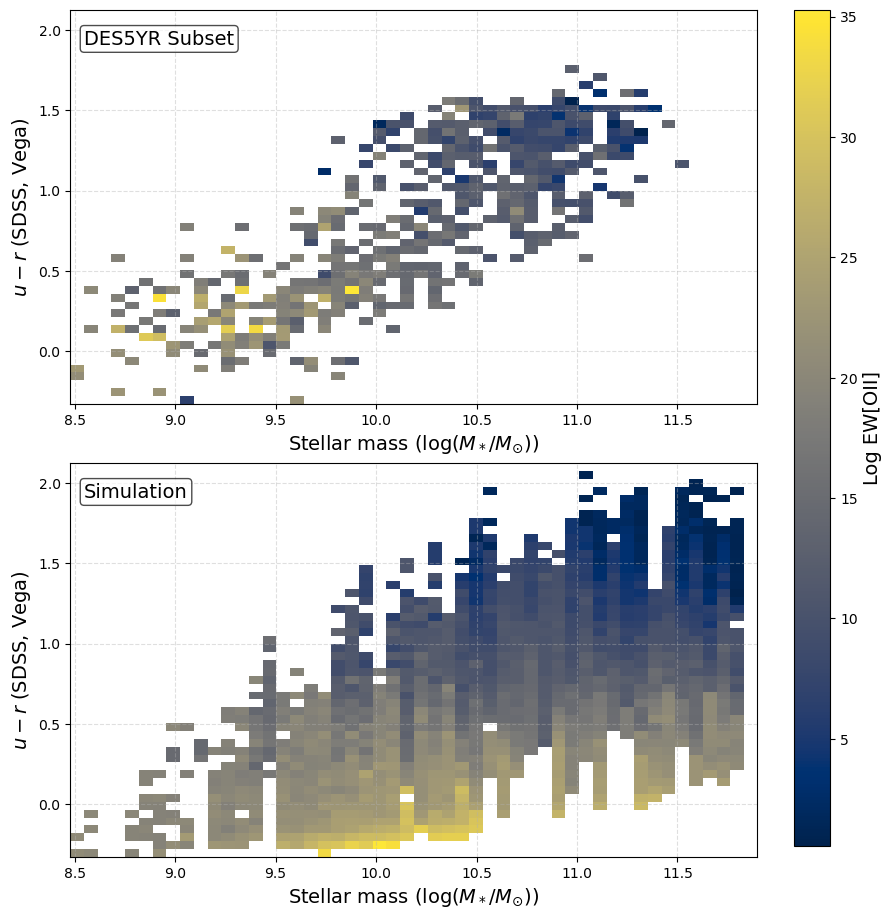

In [14]:
# ==== 2D histogram function ====
def compute_2d_hist(x, y, z, nbins=50):
    x_edges = np.linspace(x.min(), x.max(), nbins)
    y_edges = np.linspace(y.min(), y.max(), nbins)
    x_idx = np.digitize(x, x_edges)
    y_idx = np.digitize(y, y_edges)
    Z = np.full((nbins, nbins), np.nan)
    for i in range(1, nbins):
        for j in range(1, nbins):
            mask = (x_idx == i) & (y_idx == j)
            if np.any(mask):
                Z[j - 1, i - 1] = np.nanmean(z[mask])
    return Z, x_edges, y_edges

# ==== Compute both ====
obs_Z, x_edges, y_edges = compute_2d_hist(obs_mass, obs_color, obs_oii)
sim_Z, _, _ = compute_2d_hist(sim_mass, sim_color, sim_oii)

# ==== Plot (vertical layout) ====
fig, axes = plt.subplots(
    2, 1, figsize=(9.1, 11), sharex=True, sharey=True,
    gridspec_kw={'hspace': 0.15, 'right': 0.88}  # increase hspace
)


# Observational data
# ==== Observational data ====
im1 = axes[0].imshow(
    obs_Z, origin='lower',
    extent=[x_edges.min(), x_edges.max(), y_edges.min(), y_edges.max()],
    aspect='auto', cmap='cividis'
)
axes[0].set_xlabel(r'Stellar mass ($\log(M_*/M_{\odot})$)', fontsize=14)
axes[0].set_ylabel(r'$u - r$ (SDSS, Vega)', fontsize=14)
axes[0].grid(alpha=0.4, linestyle='--')
# Force x-axis ticks to be visible on the first subplot
axes[0].tick_params(labelbottom=True)


# Add title *inside* top-right corner
axes[0].text(
    0.02, 0.95, "DES5YR Subset",
    transform=axes[0].transAxes, ha='left', va='top',
    fontsize=14,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.7)
)

# ==== Simulation data ====
im2 = axes[1].imshow(
    sim_Z, origin='lower',
    extent=[x_edges.min(), x_edges.max(), y_edges.min(), y_edges.max()],
    aspect='auto', cmap='cividis'
)
axes[1].set_xlabel(r'Stellar mass ($\log(M_*/M_{\odot})$)', fontsize=14)
axes[1].set_ylabel(r'$u - r$ (SDSS, Vega)', fontsize=14)
axes[1].grid(alpha=0.4, linestyle='--')

# Add title *inside* top-right corner
axes[1].text(
     0.02, 0.95, "Simulation",
    transform=axes[1].transAxes, ha='left', va='top',
    fontsize=14,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.7)
)

# === Shared colorbar on the right, full height ===
cbar_ax = fig.add_axes([0.92, 0.12, 0.04, 0.76])  # [left, bottom, width, height]
cb = plt.colorbar(im2, cax=cbar_ax)
cb.set_label('Log EW[OII]', fontsize=14)



plt.show()


# COMPARE WITH OBSERVATIONAL DATA

In [15]:
#just some redefinition for observed data
df_merged = pd.read_csv('df_merged_new.csv')
# show all rows
pd.set_option("display.max_rows", None)

In [16]:
from matplotlib.gridspec import GridSpec
from scipy.stats import ks_2samp

In [17]:
def annotate_stats(ax, data_obs, data_sim, bins, show_reduced=True):
    """
    data_obs: array-like (DES subset)
    data_sim: array-like (sim)
    bins: bin edges used for histograms
    Returns counts_sim_scaled, counts_obs, errors, chi2, chi2_red, counts_sim
    """
    # KS test (on raw samples)
    D, p = ks_2samp(data_obs, data_sim)

    # Histogram counts
    counts_obs, _ = np.histogram(data_obs, bins=bins)   # Ndata_i
    counts_sim, _ = np.histogram(data_sim, bins=bins)   # Nsim_i (before scaling)
    #print(f"Counts obs: {counts_obs}, Counts sim: {counts_sim}")

    # Normalise sim counts to DES total
    #if counts_sim.sum() > 0:
        #scale_factor = counts_obs.sum() / counts_sim.sum()
    #else:
        #scale_factor = 0.0

    scale_factor =  counts_obs.sum() / counts_sim.sum()
    print(f"Scale factor: {scale_factor}")
    counts_sim_scaled = counts_sim * scale_factor      # use this as Nsim_i in formula

    # Errors on data (Poisson)
    errors = np.sqrt(counts_obs)
    errors_sim= np.sqrt(counts_sim_scaled)

    # Mask bins where error > 0 (avoid divide-by-zero)
    mask = errors > 0

    # Compute chi^2 using formula
    if np.any(mask):
        chi2 = np.sum(((counts_obs[mask] - counts_sim_scaled[mask]) ** 2) / (errors[mask] ** 2 + errors_sim[mask] ** 2))
        ndof = np.count_nonzero(mask) - 1
        chi2_red = chi2 / ndof if (show_reduced and ndof > 0) else np.nan
    else:
        chi2 = np.nan
        chi2_red = np.nan
        ndof = 0

    # Annotate: show KS and chi2
    #ann = f'D={D:.2f}, p={p:.2g}\n$\\chi^2_{{\\nu}}$ = {chi2_red:.2f}'
    ann = f'$\\chi^2_{{\\nu}}$ = {chi2_red:.2f}'
    ax.text(
        0.03, 0.97,
        ann,
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.0),
        fontsize=13
    )

    return counts_sim_scaled, counts_obs, errors, chi2, chi2_red, counts_sim

# Shared binning helper
def get_bins(data1, data2, bins=24):
    combined = pd.concat([data1, data2])
    return np.histogram_bin_edges(combined, bins=bins)

# Helper for bin centers
def get_bin_centers(bins):
    return (bins[:-1] + bins[1:]) / 2


Scale factor: 0.011551833122629583
Scale factor: 0.011551833122629583
Scale factor: 0.011551833122629583
Number of sim EW_OII < 0: 0
Scale factor: 0.010982932996207333


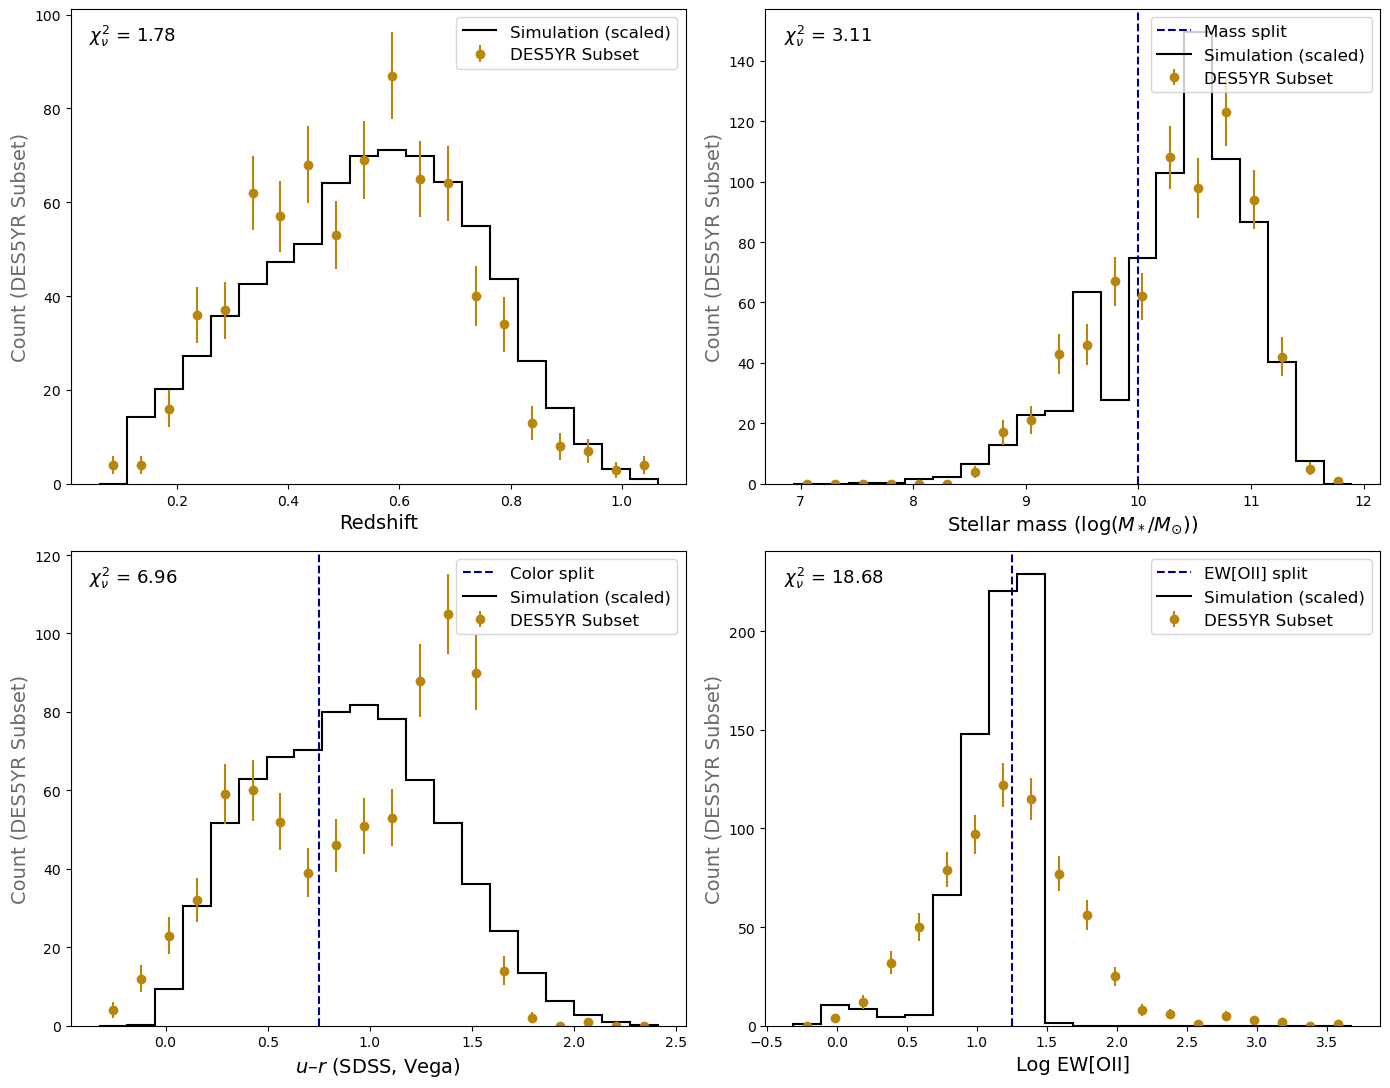

Scale factor: 0.011551833122629583
Scale factor: 0.011551833122629583
Scale factor: 0.011551833122629583


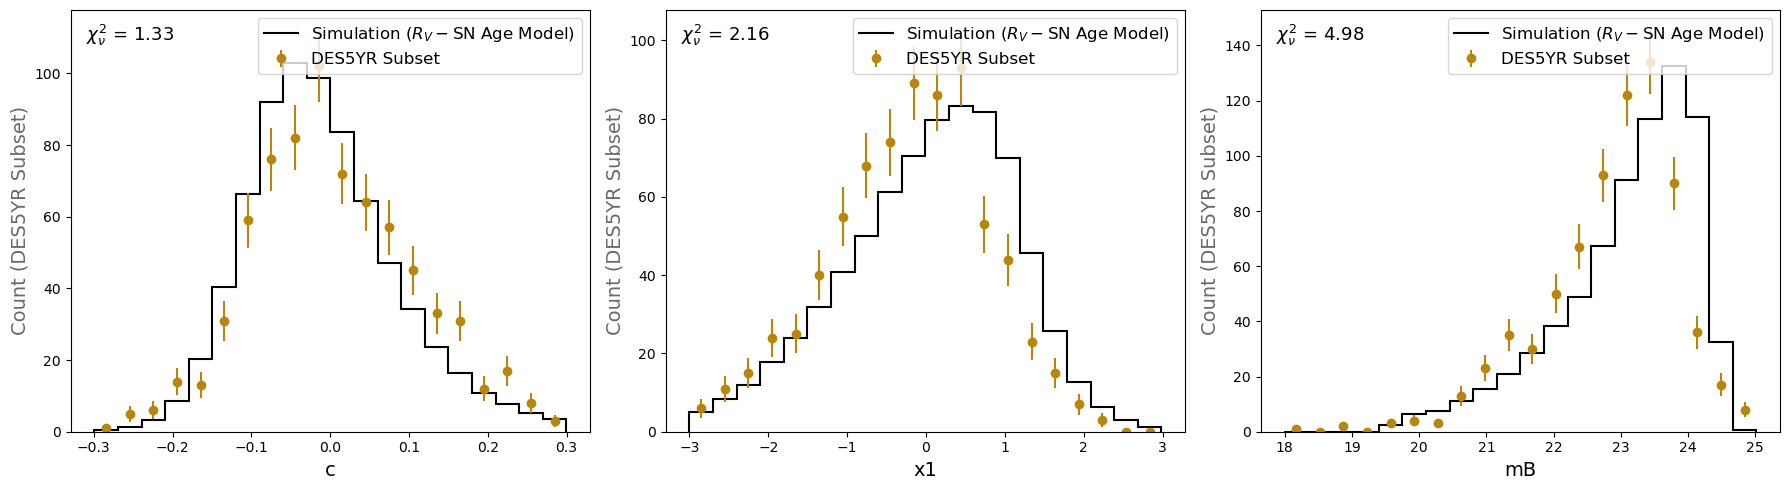

In [18]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# --- First figure: 2x2 grid ---
fig1 = plt.figure(figsize=(14, 11))
gs1 = GridSpec(2, 2, figure=fig1)

panels1 = [
    ('zHD', 'zHD', 'Redshift',20),
    ('HOST_LOGMASS', 'HOST_LOGMASS', 'Stellar mass ($\log(M_*/M_{\odot})$)', 20),
    ('HOST_COLOR', 'U-R', '$u – r$ (SDSS, Vega)',20),
    ('LOG_OII', 'EW_OII', 'Log EW[OII]', 20)
]

axes1 = []
for i in range(2):
    for j in range(2):
        axes1.append(fig1.add_subplot(gs1[i, j]))

for ax, (obs_col, sim_col, xlabel, n_bins) in zip(axes1, panels1):
    data_obs = df_merged[obs_col].dropna()
    data_sim = df[sim_col].dropna()
    if sim_col == 'EW_OII':
        data_sim_below= data_sim[data_sim < 0]
        print(f"Number of sim EW_OII < 0: {len(data_sim_below)}")
        data_sim = np.log10(data_sim[data_sim > 0])
        ax.axvline(x=1.25, color='darkblue', linestyle='--', linewidth=1.5, label='EW[OII] split')

    if obs_col == 'HOST_COLOR':
        ax.axvline(x=0.75, color='darkblue', linestyle='--', linewidth=1.5, label='Color split')
        data_obs = data_obs 
    if obs_col == 'HOST_LOGMASS':
        ax.axvline(x=10, color='darkblue', linestyle='--', linewidth=1.5, label='Mass split')
    bins = get_bins(data_sim, data_obs, n_bins)
    centers = get_bin_centers(bins)
    counts_sim_scaled, counts_obs, errors, chi2, chi2_red, counts_sim = annotate_stats(ax, data_obs, data_sim, bins)
    ax.errorbar(centers, counts_obs, yerr=errors, fmt='o', color='darkgoldenrod', label='DES5YR Subset')

    # use bin edges for a proper step; stairs handles it cleanly
    ax.stairs(counts_sim_scaled, bins, linewidth=1.5, color='black', label='Simulation (scaled)')

    #ax.set_ylabel('Count per bin')
    ax.legend(loc='upper left')
    #ax.errorbar(centers, counts_obs, yerr=errors, fmt='o', color='darkgoldenrod', label='DES5YR')
    #ax2 = ax.twinx()
    #ax2.step(centers, counts_sim, where='mid', color='darkgrey', linewidth=1.5, label='Sim')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel('Count (DES5YR Subset)', color='dimgrey', fontsize=14)
    #ax2.set_ylabel('Count (Sim)', color='darkblue')
    #ax.set_title(f'{xlabel} Histogram Comparison')
    ax.legend(loc='upper right', fontsize=12)
    #ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# --- Second figure: 1x3 grid ---
fig2 = plt.figure(figsize=(18, 5))
gs2 = GridSpec(1, 3, figure=fig2)

panels2 = [
    ('c', 'c', 'c', 20),
    ('x1', 'x1', 'x1', 20),
    ('mB', 'mB', 'mB', 20)
]

axes2 = [fig2.add_subplot(gs2[0, i]) for i in range(3)]

for ax, (obs_col, sim_col, xlabel, n_bins) in zip(axes2, panels2):
    data_obs = df_merged[obs_col].dropna()
    data_sim = df[sim_col].dropna()
    bins = get_bins(data_sim, data_obs, bins=n_bins)
    centers = get_bin_centers(bins)
    counts_sim_scaled, counts_obs, errors, chi2, chi2_red, counts_sim = annotate_stats(ax, data_obs, data_sim, bins)
    ax.errorbar(centers, counts_obs, yerr=errors, fmt='o', color='darkgoldenrod', label='DES5YR Subset')

    # use bin edges for a proper step; stairs handles it cleanly
    ax.stairs(counts_sim_scaled, bins, linewidth=1.5, color='black', label='Simulation ($R_V-$SN Age Model)')

    #ax.set_ylabel('Count per bin')
    ax.legend(loc='upper left')
    #ax.errorbar(centers, counts_obs, yerr=errors, fmt='o', color='darkgoldenrod', label='DES5YR')
    #ax2 = ax.twinx()
    #ax2.step(centers, counts_sim, where='mid', color='darkgrey', linewidth=1.5, label='Sim')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel('Count (DES5YR Subset)', color='dimgrey', fontsize=14)
    #ax2.set_ylabel('Count (Sim)', color='darkblue')
    #ax.set_title(f'{xlabel} Histogram Comparison')
    ax.legend(loc='upper right', fontsize=12)
    #ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


Scale factor: 0.011551833122629583
Scale factor: 0.011551833122629583
Scale factor: 0.011551833122629583
Number of sim EW_OII < 0: 0
Scale factor: 0.010982932996207333


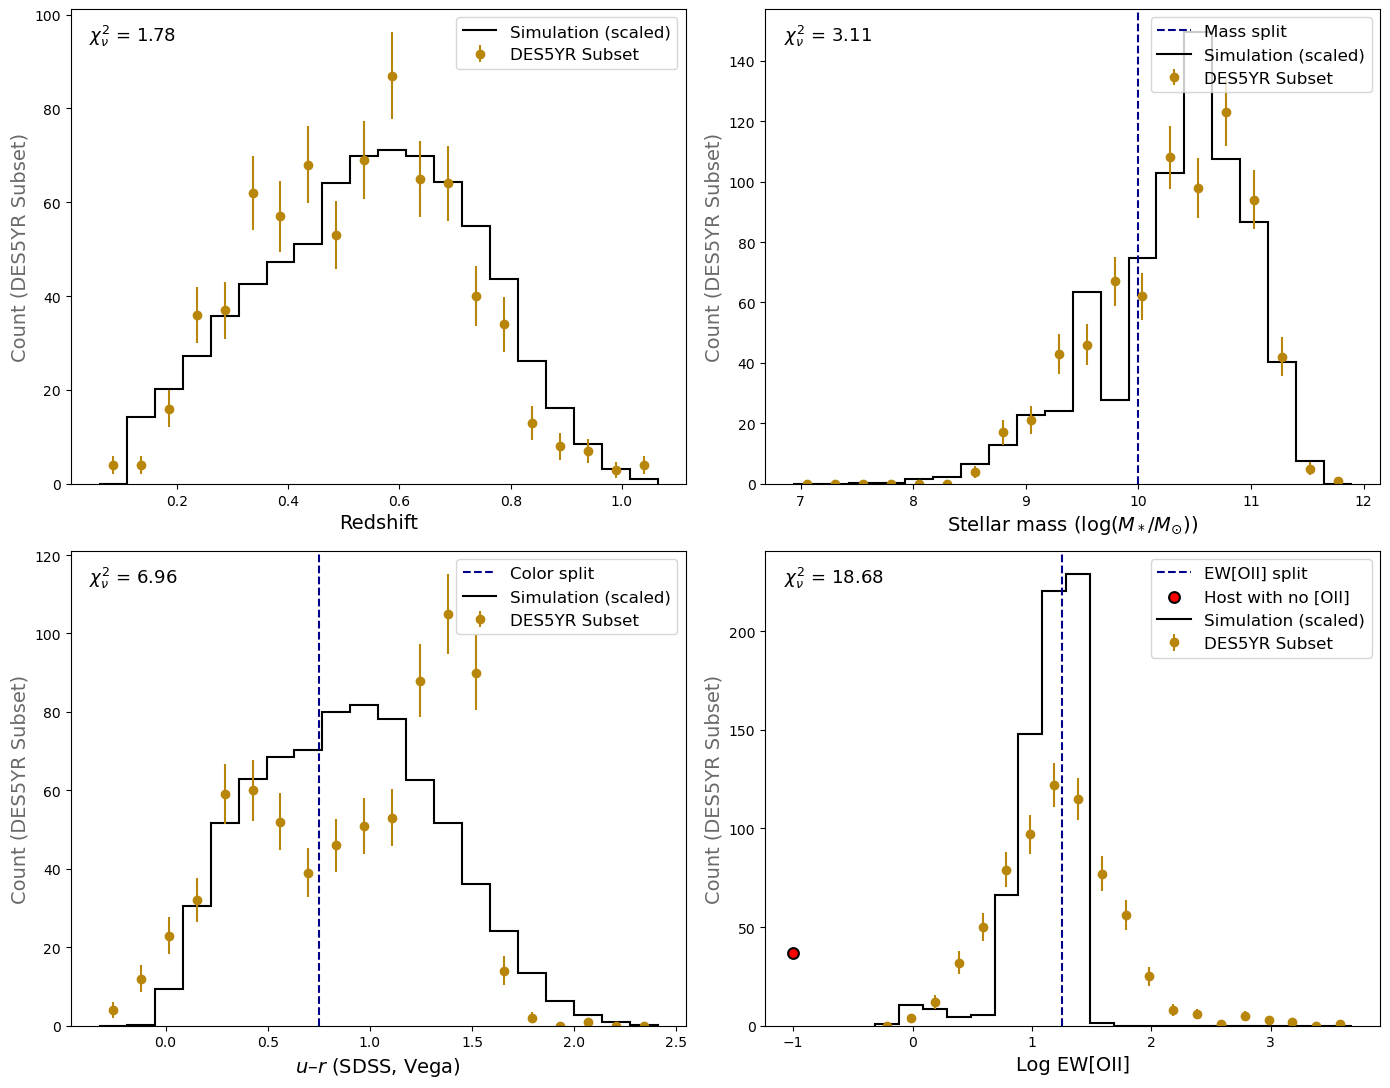

Scale factor: 0.011551833122629583
Scale factor: 0.011551833122629583
Scale factor: 0.011551833122629583


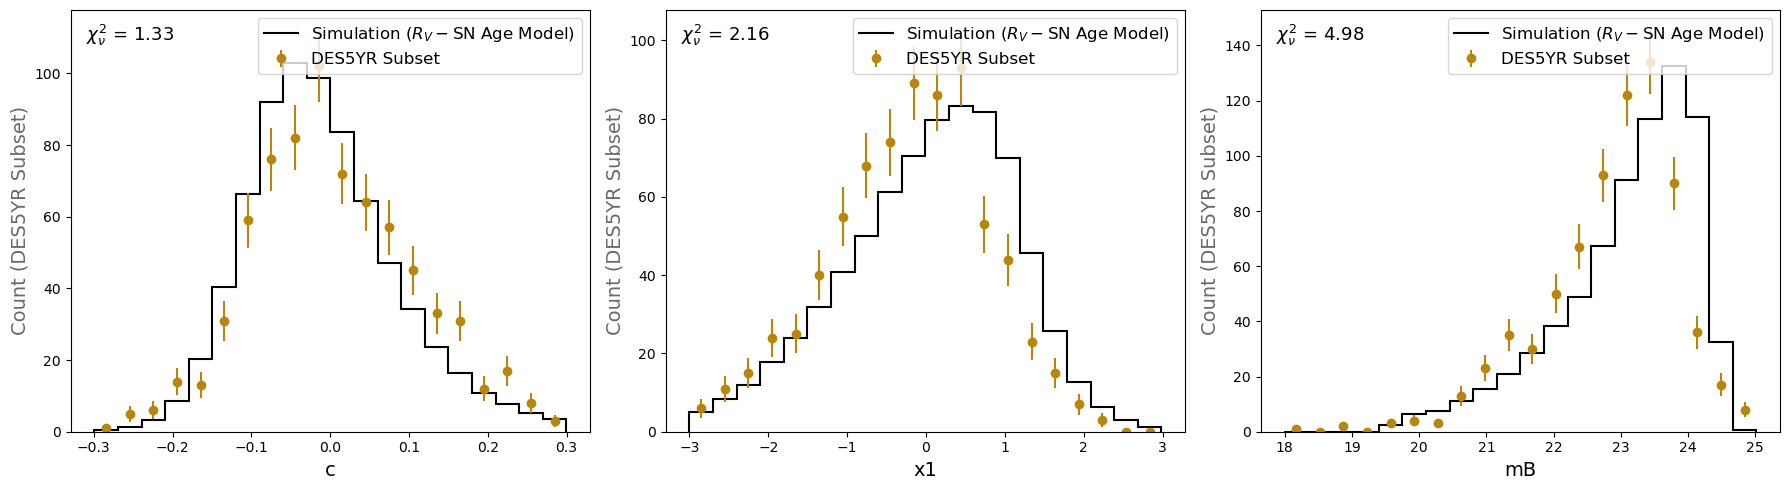

In [20]:
#SAME VERSION WITH EXTRA POINT FOR HOSTS WITH NO OII

# --- First figure: 2x2 grid ---
fig1 = plt.figure(figsize=(14, 11))
gs1 = GridSpec(2, 2, figure=fig1)

panels1 = [
    ('zHD', 'zHD', 'Redshift',20),
    ('HOST_LOGMASS', 'HOST_LOGMASS', 'Stellar mass ($\log(M_*/M_{\odot})$)', 20),
    ('HOST_COLOR', 'U-R', '$u – r$ (SDSS, Vega)',20),
    ('LOG_OII', 'EW_OII', 'Log EW[OII]', 20)
]

axes1 = []
for i in range(2):
    for j in range(2):
        axes1.append(fig1.add_subplot(gs1[i, j]))

for ax, (obs_col, sim_col, xlabel, n_bins) in zip(axes1, panels1):
    data_obs = df_merged[obs_col].dropna()
    data_sim = df[sim_col].dropna()
    
    if sim_col == 'EW_OII':
        # Handle EW_OII separately
        data_sim_below = data_sim[data_sim < 0]
        print(f"Number of sim EW_OII < 0: {len(data_sim_below)}")
        data_sim = np.log10(data_sim[data_sim > 0])
        ax.axvline(x=1.25, color='darkblue', linestyle='--', linewidth=1.5, label='EW[OII] split')

        # Add the extra point for hosts with no OII
        ax.scatter(x=-1, y=37, color='red', s=60, edgecolors='black', linewidths=1.5, marker='o', label='Host with no [OII]')

    if obs_col == 'HOST_COLOR':
        ax.axvline(x=0.75, color='darkblue', linestyle='--', linewidth=1.5, label='Color split')
    
    if obs_col == 'HOST_LOGMASS':
        ax.axvline(x=10, color='darkblue', linestyle='--', linewidth=1.5, label='Mass split')
    
    bins = get_bins(data_sim, data_obs, n_bins)
    centers = get_bin_centers(bins)
    counts_sim_scaled, counts_obs, errors, chi2, chi2_red, counts_sim = annotate_stats(ax, data_obs, data_sim, bins)
    
    ax.errorbar(centers, counts_obs, yerr=errors, fmt='o', color='darkgoldenrod', label='DES5YR Subset')
    ax.stairs(counts_sim_scaled, bins, linewidth=1.5, color='black', label='Simulation (scaled)')

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel('Count (DES5YR Subset)', color='dimgrey', fontsize=14)
    
    # Only add legend to the EW[OII] panel (bottom-right)
    if sim_col == 'EW_OII':
        ax.legend(loc='upper right', fontsize=12)
    else: 
        ax.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

# --- Second figure: 1x3 grid ---
fig2 = plt.figure(figsize=(18, 5))
gs2 = GridSpec(1, 3, figure=fig2)

panels2 = [
    ('c', 'c', 'c', 20),
    ('x1', 'x1', 'x1', 20),
    ('mB', 'mB', 'mB', 20)
]

axes2 = [fig2.add_subplot(gs2[0, i]) for i in range(3)]

for ax, (obs_col, sim_col, xlabel, n_bins) in zip(axes2, panels2):
    data_obs = df_merged[obs_col].dropna()
    data_sim = df[sim_col].dropna()
    bins = get_bins(data_sim, data_obs, bins=n_bins)
    centers = get_bin_centers(bins)
    counts_sim_scaled, counts_obs, errors, chi2, chi2_red, counts_sim = annotate_stats(ax, data_obs, data_sim, bins)
    ax.errorbar(centers, counts_obs, yerr=errors, fmt='o', color='darkgoldenrod', label='DES5YR Subset')

    # use bin edges for a proper step; stairs handles it cleanly
    ax.stairs(counts_sim_scaled, bins, linewidth=1.5, color='black', label='Simulation ($R_V-$SN Age Model)')

    #ax.set_ylabel('Count per bin')
    ax.legend(loc='upper left')
    #ax.errorbar(centers, counts_obs, yerr=errors, fmt='o', color='darkgoldenrod', label='DES5YR')
    #ax2 = ax.twinx()
    #ax2.step(centers, counts_sim, where='mid', color='darkgrey', linewidth=1.5, label='Sim')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel('Count (DES5YR Subset)', color='dimgrey', fontsize=14)
    #ax2.set_ylabel('Count (Sim)', color='darkblue')
    #ax.set_title(f'{xlabel} Histogram Comparison')
    ax.legend(loc='upper right', fontsize=12)
    #ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()
